<a href="https://colab.research.google.com/github/Nicole0906/DLI_Group_Assignment/blob/main/Nicole_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change directory to the desired location in Google Drive
import os
os.chdir('/content/gdrive/MyDrive')


Mounted at /content/gdrive


Traning Model

✅ Dataset loaded successfully!
Shape: (10000, 50)
Columns: ['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath', 'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT', 'CLASS_LABEL']

Feature shape: (1000

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:18:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Confusion Matrix:
 [[988  12]
 [ 13 987]]

📑 Tuned Evaluation Table:

+----------------+-------------+----------+------------+-----------+------------------------------+
| Class          |   Precision | Recall   |   F1-score | Support   |   Inference Time (ms/sample) |
+================+=============+==========+============+===========+==============================+
| 0 (Legitimate) |       0.987 | 0.988    |      0.988 | 1000      |                        0.054 |
+----------------+-------------+----------+------------+-----------+------------------------------+
| 1 (Phishing)   |       0.988 | 0.987    |      0.987 | 1000      |                        0.054 |
+----------------+-------------+----------+------------+-----------+------------------------------+
| Accuracy       |       0.988 | Accuracy |      0.988 | Accuracy  |                        0.988 |
+----------------+-------------+----------+------------+-----------+------------------------------+
| Macro avg      |       0.

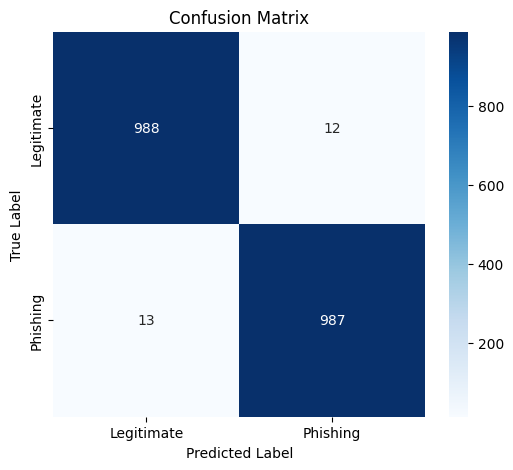

In [42]:
# ==============================
# STEP 1: Install dependencies
# ==============================
!pip install -q xgboost scikit-learn tabulate gdown

# ==============================
# STEP 2: Imports & Reproducibility
# ==============================
import os, random, time, subprocess
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

# ---- Reproducibility: set ALL the seeds ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ==============================
# STEP 3: Fetch & Load dataset from GitHub
# ==============================
REPO_URL = "https://github.com/Nicole0906/DLI_Group_Assignment.git"
CLONE_DIR = "./DLI_Group_Assignment"

if not os.path.exists(CLONE_DIR):
    print(f"⬇️  Cloning repository from: {REPO_URL}")
    subprocess.run(["git", "clone", REPO_URL, CLONE_DIR], check=True)

DATA_PATH = os.path.join(CLONE_DIR, "Phishing_Legitimate_full 3.csv")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ==============================
# STEP 4: Define features & target
# ==============================
TARGET_COL = "CLASS_LABEL"
ID_COLS = [c for c in ["id"] if c in df.columns]

X = df.drop(columns=ID_COLS + [TARGET_COL])
y = df[TARGET_COL]

print("\nFeature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

unique_labels = sorted(y.unique())
label_map = {0: "Legitimate", 1: "Phishing"}
for lbl in unique_labels:
    if lbl not in label_map:
        label_map[lbl] = f"Class {lbl}"

# ==============================
# STEP 5: Train-test split (seeded)
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("\nData Split:")
print("Train size:", X_train.shape, "Test size:", X_test.shape)

# ==============================
# STEP 6: Train Tuned XGBoost Model
# ==============================
model = xgb.XGBClassifier(
    n_estimators=700,          # more trees
    learning_rate=0.03,        # slower learning
    max_depth=7,               # deeper trees
    max_leaves=80,             # more leaves
    subsample=0.95,            # more samples per tree
    colsample_bytree=0.95,     # more features per tree
    gamma=0.1,                 # minimal loss reduction
    min_child_weight=2,        # min sum of instance weight per child
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=1
)

print("\n🚀 Training Tuned XGBoost model...")
model.fit(X_train, y_train)

# ==============================
# STEP 7: Evaluate the tuned model
# ==============================
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
inference_time = (end - start) / len(X_test) * 1000.0  # ms/sample

print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

# ==============================
# STEP 8: Build Custom Evaluation Table
# ==============================
classes = sorted(unique_labels)
table_rows = []
for cls in classes:
    cls_key = str(cls)
    if cls_key in report:
        table_rows.append([
            f"{cls} ({label_map.get(cls, f'Class {cls}')})",
            round(report[cls_key]["precision"], 3),
            round(report[cls_key]["recall"], 3),
            round(report[cls_key]["f1-score"], 3),
            int(report[cls_key]["support"]),
            round(inference_time, 3),
        ])

# Accuracy, Macro avg, Weighted avg
table_rows.extend([
    ["Accuracy", round(report["accuracy"], 3)]*3 + [len(y_test), round(inference_time, 3)],
    ["Macro avg", round(report["macro avg"]["precision"], 3),
     round(report["macro avg"]["recall"], 3),
     round(report["macro avg"]["f1-score"], 3),
     int(report["macro avg"]["support"]), round(inference_time, 3)],
    ["Weighted avg", round(report["weighted avg"]["precision"], 3),
     round(report["weighted avg"]["recall"], 3),
     round(report["weighted avg"]["f1-score"], 3),
     int(report["weighted avg"]["support"]), round(inference_time, 3)]
])

print("\n📑 Tuned Evaluation Table:\n")
print(tabulate(
    table_rows,
    headers=["Class", "Precision", "Recall", "F1-score", "Support", "Inference Time (ms/sample)"],
    tablefmt="grid"
))

# ==============================
# STEP 9: Print Final F1 Score + Verdict
# ==============================
final_f1 = round(report["weighted avg"]["f1-score"], 3)
TARGET_F1 = 0.98
verdict = "target met ✅" if final_f1 >= TARGET_F1 else "target not met ❌"
print(f"\n🎯 Final F1 Score: {final_f1}")
print(f"✅ Verdict: Achieved F1 = {final_f1}, target = {TARGET_F1} → {verdict}")

# ==============================
# STEP 10: Plot Confusion Matrix
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in sorted(unique_labels)],
            yticklabels=[label_map[i] for i in sorted(unique_labels)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
